# Dataset Analysis
The purpose of this notebook is to get an understanding of the images currently contained in approximately 1/4 of the dataset and visualize the discrepancies in the distribution between the original dataset and the partial dataset. Regardless, the task will be completed with a subset of the partial dataset that is closest to the original (or at least the live training samples will be taken from the same distribution generating function).

In [1]:
import numpy as np
import pandas as pd
import json
import matplotlib.pyplot as plt
%matplotlib inline

### Original Dataset

In [2]:
with open('./train/metadata.json', 'r') as dsFile:
    tdjson = json.load(dsFile)

In [3]:
# What information do we have
tdjson.keys()

dict_keys(['annotations', 'categories', 'images', 'info', 'licenses', 'institutions'])

So this dataset has a json file with further embedded dictionaries containing these respective informations. In order to combine all information into a relevant dataframe, we must properly append / adjust column values to be legible.

In [4]:
# Take annotations and combine them with the image paths
tdf = pd.DataFrame.from_dict(tdjson['annotations'])
tdfPaths = pd.DataFrame.from_dict(tdjson['images'])
tdfLabels = pd.DataFrame.from_dict(tdjson['categories'])

# Labeling lambda
labLam = lambda ind:tdfLabels['name'][ind]

# Now go ahead and combine the respective dataframe entries
# into a relevant dataframe
tdf['filepath'] = tdfPaths['file_name']
tdf['species'] = tdf['category_id'].map(labLam)

In [5]:
tdf

category_id       id  image_id  institution_id  \
0              60492  1814367   1814367               0   
1              10824  1308257   1308257               0   
2              33076  1270453   1270453               3   
3              24799  1123834   1123834               0   
4              17018  1042410   1042410               0   
...              ...      ...       ...             ...   
2257754        51130   812040    812040               0   
2257755        35499   701754    701754               0   
2257756        56547   662006    662006               0   
2257757        57499   234505    234505               0   
2257758        23116   418707    418707               0   

                          filepath                                  species  
0        images/604/92/1814367.jpg             Thysanocarpus curvipes Hook.  
1        images/108/24/1308257.jpg                      Cassia grandis L.f.  
2        images/330/76/1270453.jpg                Leptospermum whitei Cheel  
3        images/247/99/1123834.jpg             Fallopia scandens (L.) Holub  
4        images/170/18/1042410.jpg                   Cyperus dentatus Torr.  
...                            ...                                      ...  
2257754   images/511/30/812040.jpg                         Quercus rubra L.  
2257755   images/354/99/701754.jpg          Malus fusca (Raf.) C.K.Schneid.  
2257756   images/565/47/662006.jpg              Solanum elaeagnifolium Cav.  
2257757   images/574/99/234505.jpg  Sphyrospermum buxifolium Poepp. & Endl.  
2257758   images/231/16/418707.jpg                   Erodium texanum A.Gray  

[2257759 rows x 6 columns]

We can now take a closer look into some interesting metrics we can determine from this dataset. The ids are of no use to us as it is merely meant for housekeeping, but having information about labels tells us the distribution of plants we have, and the filepaths will allow us to verify whether or not the file currently exists in the partial dataset.

Text(0.5, 1.0, 'Top 50 Frequent Classes [Average:35.00]')

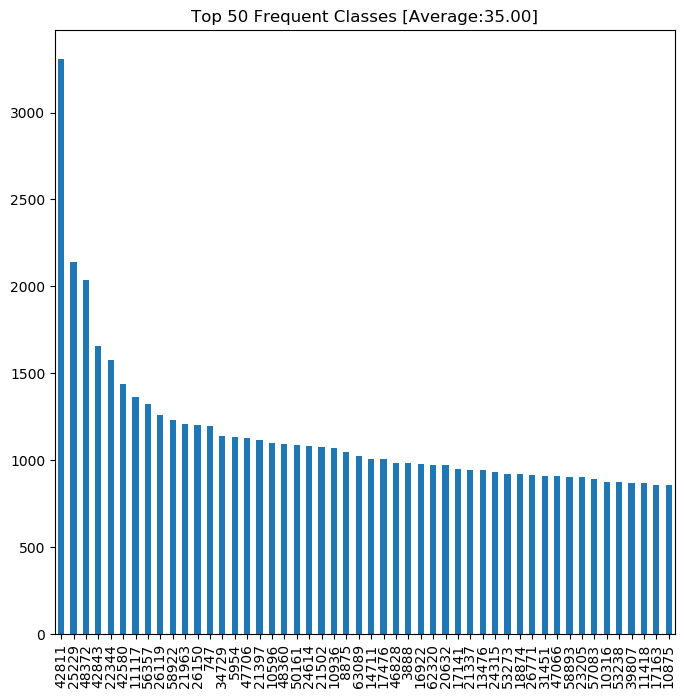

In [6]:
fig, ax = plt.subplots(dpi=100, figsize=(8,8))
tdf['category_id'].value_counts().nlargest(50).plot(ax=ax, kind='bar')
ax.set_title('Top 50 Frequent Classes [Average:{:0.2f}]'.format(tdf['category_id'].value_counts().mean()))

With an average of 35 across the dataset but the presence of 1000+ for quite a few classes, this does not bode well for our other classes... Now to take a larger look at the overall picture...

Text(0, 0.5, 'Frequency')

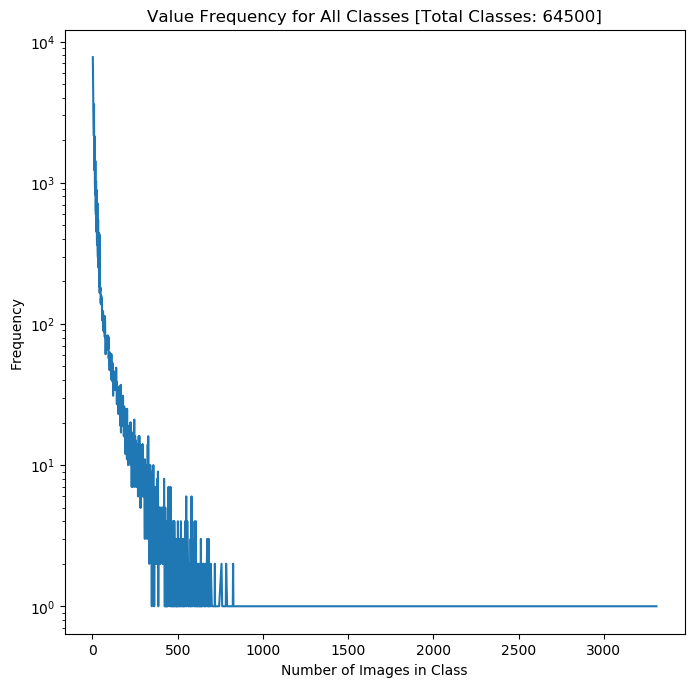

In [131]:
fig, ax = plt.subplots(dpi=100, figsize=(8,8))
impSeries = tdf['category_id'].value_counts().value_counts().sort_index()
ax.plot(impSeries.keys(), impSeries.values)
ax.set_yscale('log')
ax.set_title("Value Frequency for All Classes [Total Classes: {}]".format(len(tdf['category_id'].unique())))
ax.set_xlabel("Number of Images in Class")
ax.set_ylabel("Frequency")

Text(0.5, 0, 'Number of Images in Class')

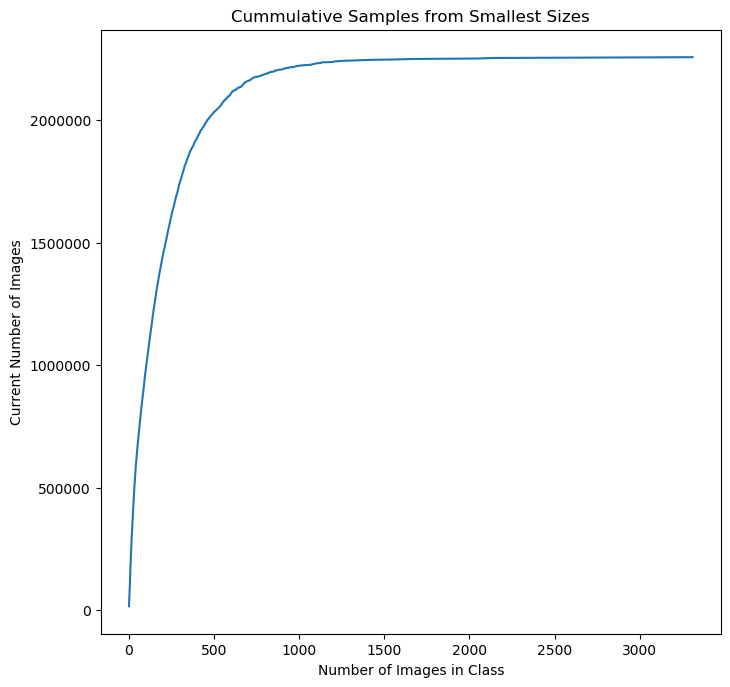

In [128]:
fig, ax = plt.subplots(dpi=100, figsize=(8,8))
test = tdf['category_id'].value_counts().value_counts().sort_index()
test = test.mul(test.index)
test.cumsum().plot(ax=ax)
ax.set_title("Cummulative Samples from Smallest Sizes")
ax.set_ylabel("Current Number of Images")
ax.set_xlabel("Number of Images in Class")

The two plots together tell us how significant the classes with only a few samples contribute to the overall bulk of the dataset. This is actually going to be detrimental to us for several reasons - the most important of which is the fact that the measurement on which we are being rated by is the __macro $F_1$ score__. The macro $F_1$ score is defined as below:

$$ \text{F}_{1}^{M}=\frac{1}{C}\sum_{i=0}^{C}F^i_1$$

where

$$ F^i_1 = \frac{2}{\text{recall}^{-1}_{\mathcal{D}_{\ i}}+\text{precision}_{\mathcal{D}_{\ i}}^{-1}}\ , \qquad {\mathcal{D}_{\ i}}=\{x\in\mathcal{D}|y_x=i\}$$

In other words, we are calculating the average of our F scores across every single class - which can severely impact our overall scores. We can surmise the following: One of the challenges of this dataset is managing the accuracy of infrequent classes with the frequent classes. Class imbalance is a typical issue on most datasets, but this metric is meant to penalize any sort of prioritizing of the larger clusters vs the smaller ones.

We can move on to analyzing the portion of the dataset that we have present now, along with discovering any issues that may be present with the samples...

### On-Hand Dataset Analysis
We begin by populating a matrix with the datasets we currently have...

In [132]:
import os.path

In [133]:
dfExists = tdf[tdf['filepath'].map(lambda x:os.path.isfile('./train/'+x))]

In [134]:
dfExists

category_id       id  image_id  institution_id  \
1              10824  1308257   1308257               0   
3              24799  1123834   1123834               0   
13             46514  1458258   1458258               0   
14             41699   226138    226138               0   
15             55942  2234628   2234628               0   
...              ...      ...       ...             ...   
2257751        42909  2244701   2244701               0   
2257754        51130   812040    812040               0   
2257756        56547   662006    662006               0   
2257757        57499   234505    234505               0   
2257758        23116   418707    418707               0   

                          filepath                                  species  
1        images/108/24/1308257.jpg                      Cassia grandis L.f.  
3        images/247/99/1123834.jpg             Fallopia scandens (L.) Holub  
13       images/465/14/1458258.jpg            Picrothamnus desertorum Nutt.  
14        images/416/99/226138.jpg    Oreogrammitis hookeri (Brack.) Parris  
15       images/559/42/2234628.jpg                     Simaba pohliana Boas  
...                            ...                                      ...  
2257751  images/429/09/2244701.jpg               Panicum polyanthes Schult.  
2257754   images/511/30/812040.jpg                         Quercus rubra L.  
2257756   images/565/47/662006.jpg              Solanum elaeagnifolium Cav.  
2257757   images/574/99/234505.jpg  Sphyrospermum buxifolium Poepp. & Endl.  
2257758   images/231/16/418707.jpg                   Erodium texanum A.Gray  

[508428 rows x 6 columns]

Text(0.5, 1.0, 'Top 50 Frequent Classes [Average:35.05]')

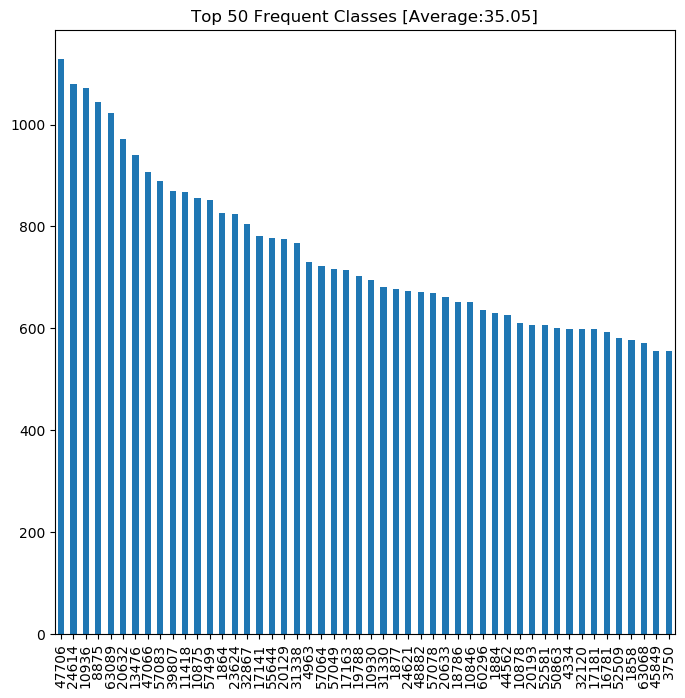

In [135]:
fig, ax = plt.subplots(dpi=100, figsize=(8,8))
dfExists['category_id'].value_counts().nlargest(50).plot(ax=ax, kind='bar')
ax.set_title('Top 50 Frequent Classes [Average:{:0.2f}]'.format(dfExists['category_id'].value_counts().mean()))

Text(0, 0.5, 'Frequency')

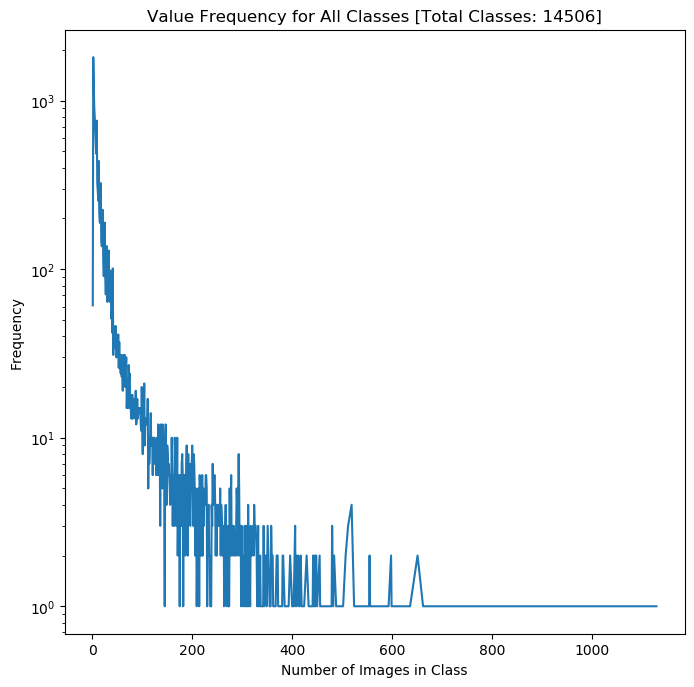

In [136]:
fig, ax = plt.subplots(dpi=100, figsize=(8,8))
impSeries = dfExists['category_id'].value_counts().value_counts().sort_index()
ax.plot(impSeries.keys(), impSeries.values)
ax.set_yscale('log')
ax.set_title("Value Frequency for All Classes [Total Classes: {}]".format(len(dfExists['category_id'].unique())))
ax.set_xlabel("Number of Images in Class")
ax.set_ylabel("Frequency")

Text(0.5, 0, 'Number of Images in Class')

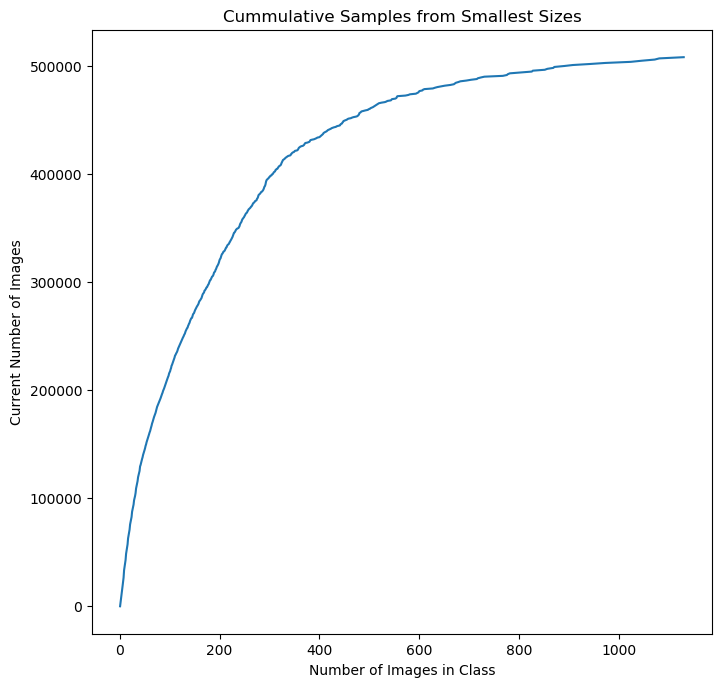

In [137]:
fig, ax = plt.subplots(dpi=100, figsize=(8,8))
test = dfExists['category_id'].value_counts().value_counts().sort_index()
test = test.mul(test.index)
test.cumsum().plot(ax=ax)
ax.set_title("Cummulative Samples from Smallest Sizes")
ax.set_ylabel("Current Number of Images")
ax.set_xlabel("Number of Images in Class")

We are clearly missing a large chunk of classes in our dataset... We have inadvertedly created a bit larger of a shift to classes with a larger numbers of samples (which makes sense considering the transfer method used randomly chose files without paying too much mind to the directory structure), but training properly on this subset should give some adequate idea of whether or not our technique can be properly applied to the set. A significant number of classes with only a few examples have been lost...

Now let's plot some images along with their classes to see what exactly we are dealing with here...

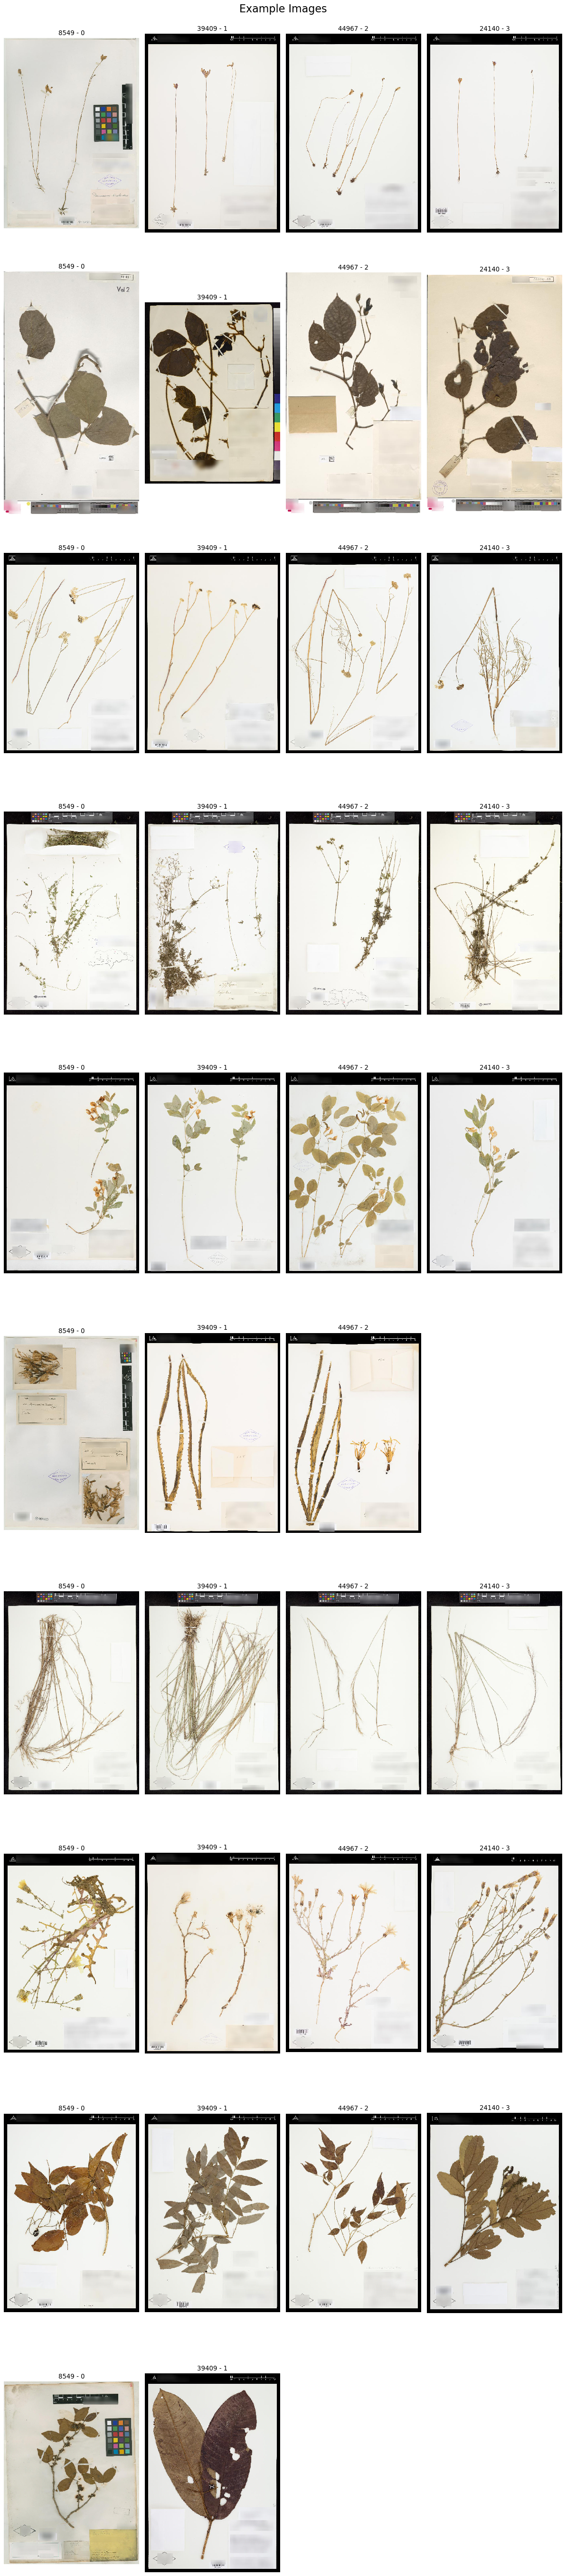

In [138]:
SAMPLE_ROWS = 10
SAMPLE_COLS = 4 # decently large subset has at least 4 unique images
curClassArr = dfExists['category_id'].unique()

# Sample classes
fig, ax = plt.subplots(SAMPLE_ROWS, SAMPLE_COLS, figsize=(15,70), dpi=80)
curClassArr = curClassArr[np.random.choice(curClassArr.shape[0], SAMPLE_ROWS, replace=False)]
for rInd in range(SAMPLE_ROWS):
    # Randomly plot images as necessary
    relDf = dfExists[dfExists['category_id']==curClassArr[rInd]]
    relDf = relDf.sample(frac=1).reset_index(drop=True)['filepath'].values
    for cInd in range(SAMPLE_COLS):
        if(cInd < len(relDf)):
            ax[rInd][cInd].imshow(plt.imread('./train/'+relDf[cInd]))
            ax[rInd][cInd].set_axis_off()
            ax[rInd][cInd].set_title('{} - {}'.format(curClassArr[cInd], cInd))
        else:
            fig.delaxes(ax[rInd][cInd])
fig.suptitle('Example Images', fontsize=20)
fig.tight_layout()
fig.subplots_adjust(top=0.98)

So here we see another big issue with this dataset... While there are sets with a large number of images, there is a distinct lack of proper curation for many of these images. They are meant to have the color swabs in order to properly colorize them, but there's a lack of those swabs on many images, and not only is there a lack of proper positioning on many of these images, but some images don't even look like they were properly pressed and photographed!

In other words, this is a problem where the inter-class variation seems to be quite minimal, while the intra-class variation can be large and the myriad of possible poses will likely not even be able to be estimated with most of these images! This is known as the fine-grained classification problem, and it will likely require a finely tailed ensemble of networks in order to classify many of these images... There should also be a GAN approach, but that will require a different SSL method to implement and thus won't be considered here...

I will discuss the approach that seems the most possible to generate decent results given the semi-supervised methods that we have covered. Obviously the most pertinent one will be the UDA consistency regularization approach, but there may be a large need for preprocessing of the dataset in order to not have anything that isn't indicative of the species being used as a relevant feature.